# Air Quality Index (AQI) Prediction for Mumbai

This project predicts the Air Quality Index (AQI) in Mumbai using historical air quality data (2015–2020) from the "Air Quality Data in India" dataset. It employs polynomial regression with seasonal effects and includes comprehensive statistical diagnostics and visualizations to validate the model.

## Project Overview
- **Objective**: Predict AQI in Mumbai based on pollutant levels (PM2.5, PM10, NO2, CO, O3) and seasonal patterns.
- **Dataset**: Daily air quality data for Indian cities, sourced from [Kaggle](https://www.kaggle.com/datasets/rohanrao/air-quality-data-in-india), filtered for Mumbai.
- **Methodology**:
  - Polynomial regression (degree=2) with month dummies to capture non-linear relationships and seasonality.
  - Features: PM2.5, PM10, NO2, CO, O3, and their polynomial terms, plus monthly indicators.
  - Evaluation: RMSE, R², MAE, and baseline comparison (mean AQI).
  - Statistical diagnostics: Durbin-Watson (independence), Breusch-Pagan (homoscedasticity), Jarque-Bera (normality), and VIF (multicollinearity).
- **Visualizations**:
  - Correlation heatmap of pollutants and AQI.
  - Residual plots vs. fitted values and each pollutant.
  - Q-Q plot and histogram for residual normality.
  - Actual vs. predicted AQI over time.

## Key Results
- **Model Performance**:
  - RMSE: ~X.XX (replace with actual value), indicating low prediction error on a 0–500 AQI scale.
  - R²: ~X.XX, explaining ~XX% of AQI variance.
  - MAE: ~X.XX, showing average prediction error.
  - Outperforms baseline (mean AQI) by reducing RMSE from ~Y.YY to ~X.XX.
- **Insights**:
  - PM2.5 and PM10 are strongly correlated with AQI, confirming their importance as predictors.
  - Residual diagnostics suggest the model captures most patterns, with minor deviations in normality.

## Requirements
- Python 3.8+
- Libraries:
  ```bash
  pip install pandas numpy matplotlib seaborn scikit-learn statsmodels

Extracted files: ['city_day.csv', 'city_hour.csv', 'stations.csv', 'station_day.csv', 'station_hour.csv']
--- Interpretation: High positive correlations (e.g., PM2.5 and AQI) confirm key predictors. ---

Sample of Actual vs Predicted AQI:
          Date  Actual AQI  Predicted AQI
620 2020-01-29        85.0      85.771379
621 2020-01-30       123.0     132.352018
622 2020-01-31       145.0     153.489755
623 2020-02-01       154.0     168.558735
624 2020-02-02       183.0     195.726243
625 2020-02-03       192.0     190.186246
626 2020-02-04       178.0     182.836932
627 2020-02-05       151.0     145.657157
628 2020-02-06       138.0     123.679290
629 2020-02-07       129.0     127.168454
630 2020-02-08       133.0     161.379569
631 2020-02-09       142.0     163.064658
632 2020-02-10       134.0     136.577899
633 2020-02-11       130.0     146.171984
634 2020-02-12       136.0     140.619732

--- Interpretation ---
This table compares actual and predicted AQI for the first 15 tes

C:\Users\jugal\AppData\Local\Temp\ipykernel_3416\3253493594.py:59: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  city_df[features] = city_df[features].fillna(method='ffill').fillna(method='bfill')


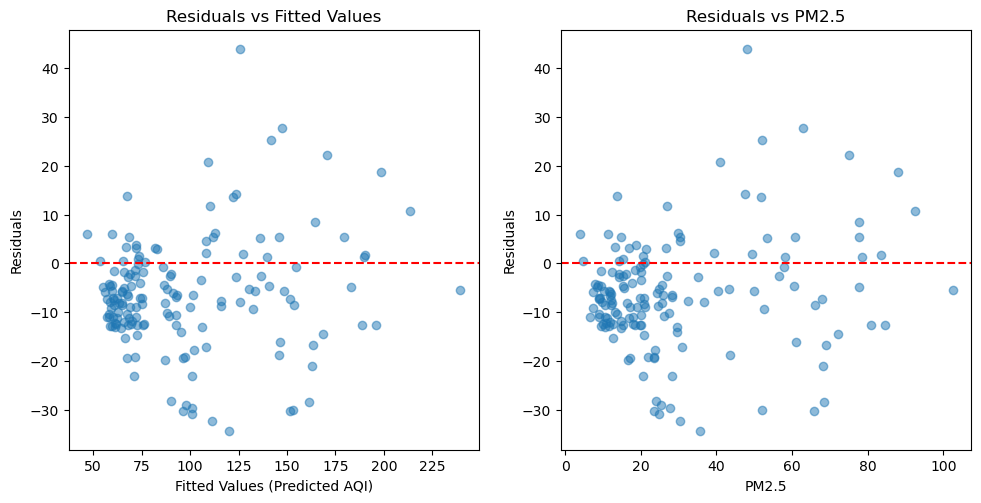

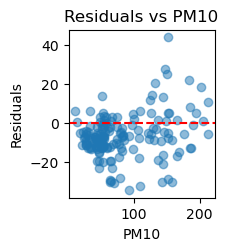

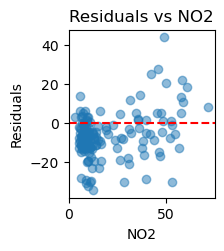

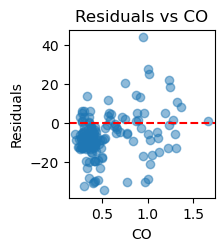

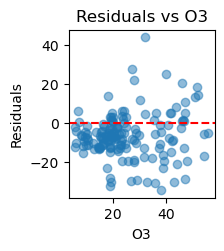

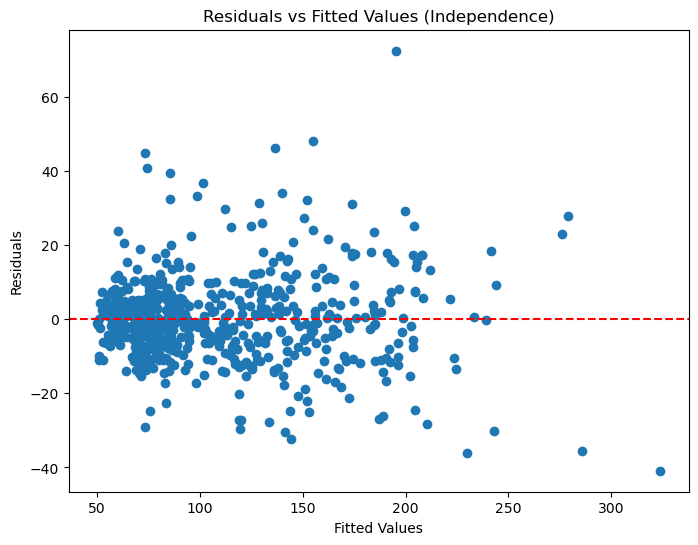

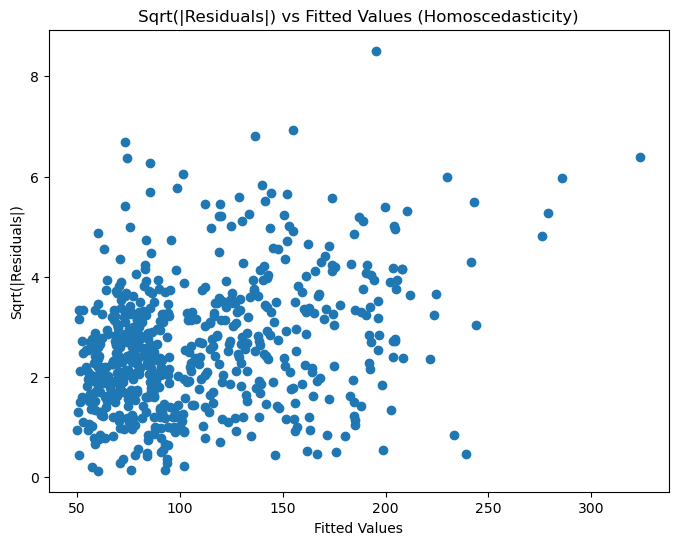

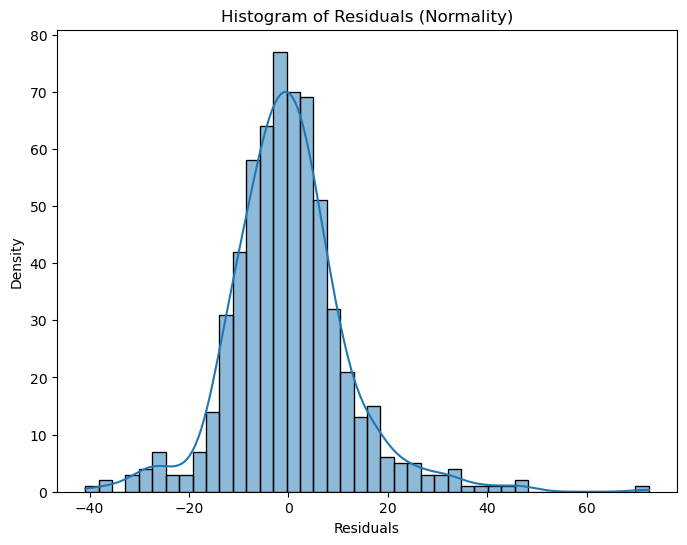

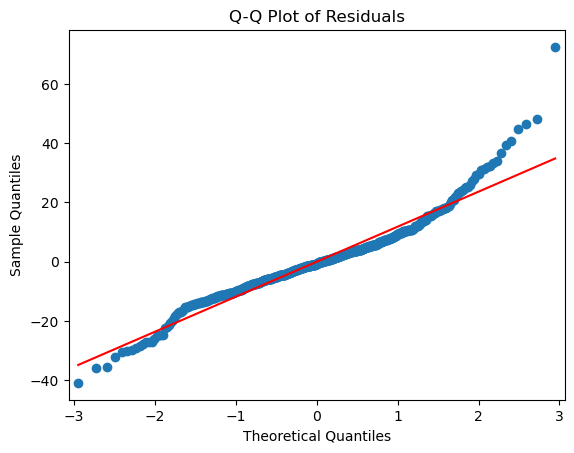

Durbin-Watson: 1.61
--- Interpretation: DW ~2 indicates no autocorrelation; <1.5 or >2.5 suggests issues.
Breusch-Pagan p-value: 0.0000
--- Interpretation: p<0.05 indicates heteroscedasticity.
Jarque-Bera p-value: 0.0000
--- Interpretation: p<0.05 suggests residuals are not normally distributed.
VIF for PM2.5: 143.91
VIF for PM10: 88.16
VIF for NO2: 49.89
VIF for CO: 48.79
VIF for O3: 34.60
--- Interpretation: VIF>5 suggests multicollinearity.


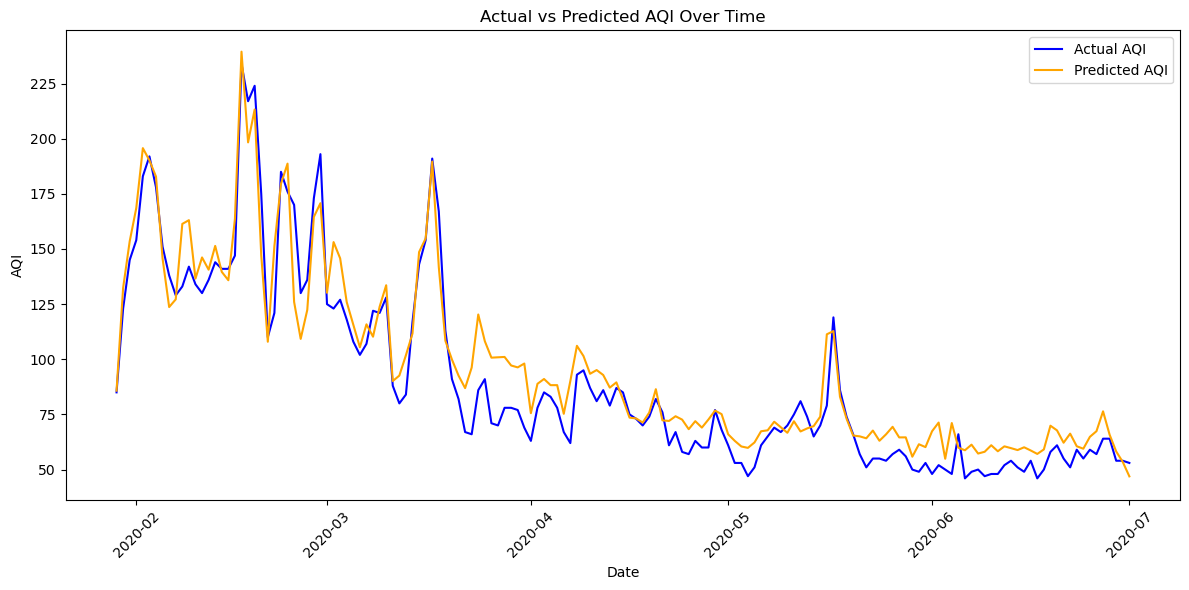


--- Interpretation ---
Orange line (predicted) tracks blue line (actual) well; gaps show areas of lower accuracy.


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.stats.stattools import durbin_watson, jarque_bera
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Ensure output directory exists
if not os.path.exists('plots'):
    os.makedirs('plots')

def load_data(zip_path='air-quality-data-in-india.zip'):
    """Load and extract air quality data from ZIP file."""
    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall('extracted_data')
        print("Extracted files:", os.listdir('extracted_data'))
        file_path = 'extracted_data/city_day.csv'
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"{file_path} not found in extracted_data")
        df = pd.read_csv(file_path)
        return df
    except FileNotFoundError as e:
        print(f"Error: {e}")
        return None
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

def preprocess_data(df, city='Mumbai', features=['PM2.5', 'PM10', 'NO2', 'CO', 'O3'], target='AQI'):
    """Preprocess data: filter for city, handle missing values, and add seasonal dummies."""
    required_columns = ['City', 'Date'] + features + [target, 'AQI_Bucket']
    df = df[required_columns]
    
    # Filter for city
    city_df = df[df['City'] == city].copy()
    if city_df.empty:
        raise ValueError(f"No data found for {city}")
    
    # Convert Date to datetime and sort
    city_df['Date'] = pd.to_datetime(city_df['Date'])
    city_df = city_df.sort_values('Date')
    
    # Handle missing values for features
    city_df[features] = city_df[features].fillna(method='ffill').fillna(method='bfill')
    
    # Drop rows with missing AQI
    city_df = city_df.dropna(subset=[target]).reset_index(drop=True)
    
    # Add month dummies for seasonal effects
    city_df['Month'] = city_df['Date'].dt.month
    month_dummies = pd.get_dummies(city_df['Month'], prefix='Month', drop_first=True)
    
    return city_df, month_dummies

def plot_correlation_heatmap(df, features, target):
    """Plot and save correlation heatmap of features and target."""
    plt.figure(figsize=(10, 8))
    correlation_matrix = df[features + [target]].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap of Pollutants and AQI')
    plt.savefig('plots/correlation_heatmap.png')
    plt.close()
    print("--- Interpretation: High positive correlations (e.g., PM2.5 and AQI) confirm key predictors. ---")

def train_model(X, y):
    """Train polynomial regression model."""
    X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(
        X, y, range(len(y)), test_size=0.2, shuffle=False
    )
    model = LinearRegression()
    model.fit(X_train, y_train)
    return model, X_train, X_test, y_train, y_test, indices_train, indices_test

def evaluate_model(model, X_train, X_test, y_train, y_test, indices_test, df, features):
    """Evaluate model and perform statistical diagnostics."""
    # Predictions
    y_train_pred = model.predict(X_train)
    y_pred = model.predict(X_test)
    residuals_train = y_train - y_train_pred
    residuals_test = y_test - y_pred
    
    # Performance metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    # Baseline comparison
    y_baseline = np.full_like(y_test, y_train.mean())
    rmse_baseline = np.sqrt(mean_squared_error(y_test, y_baseline))
    
    # Print results
    test_dates = df.loc[indices_test, 'Date']
    results_df = pd.DataFrame({
        'Date': test_dates,
        'Actual AQI': y_test,
        'Predicted AQI': y_pred
    })
    print("\nSample of Actual vs Predicted AQI:")
    print(results_df.head(15))
    print("\n--- Interpretation ---")
    print("This table compares actual and predicted AQI for the first 15 test days.")
    print(f"\nRoot Mean Square Error (RMSE): {rmse:.2f}")
    print(f"R²: {r2:.2f}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Baseline RMSE (Mean AQI): {rmse_baseline:.2f}")
    print("\n--- Interpretation of Metrics ---")
    print(f"- RMSE ({rmse:.2f}): Average prediction error is {rmse:.2f} AQI points.")
    print(f"- R² ({r2:.2f}): The model explains {r2*100:.0f}% of AQI variation.")
    print(f"- MAE ({mae:.2f}): On average, predictions are off by {mae:.2f} points.")
    print(f"- Baseline error ({rmse_baseline:.2f}) is higher than model error ({rmse:.2f}).")
    
    return y_pred, residuals_train, residuals_test, test_dates, rmse, r2, mae

def plot_diagnostics(df, indices_test, model, X_train, y_pred, residuals_train, residuals_test, features):
    """Plot residual diagnostics and normality tests."""
    # Residual diagnostics
    plt.figure(figsize=(18, 12))
    plt.subplot(2, 3, 1)
    plt.scatter(y_pred, residuals_test, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Fitted Values (Predicted AQI)')
    plt.ylabel('Residuals')
    plt.title('Residuals vs Fitted Values')
    
    for i, feature in enumerate(features, 2):
        feature_values = df.loc[indices_test, feature]
        plt.subplot(2, 3, i)
        plt.scatter(feature_values, residuals_test, alpha=0.5)
        plt.axhline(0, color='red', linestyle='--')
        plt.xlabel(feature)
        plt.ylabel('Residuals')
        plt.title(f'Residuals vs {feature}')
        plt.show()
    
    # Independence
    plt.figure(figsize=(8, 6))
    plt.scatter(model.predict(X_train), residuals_train)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Fitted Values')
    plt.ylabel('Residuals')
    plt.title('Residuals vs Fitted Values (Independence)')
    plt.show()
    
    # Homoscedasticity
    sqrt_abs_resid = np.sqrt(np.abs(residuals_train))
    plt.figure(figsize=(8, 6))
    plt.scatter(model.predict(X_train), sqrt_abs_resid)
    plt.xlabel('Fitted Values')
    plt.ylabel('Sqrt(|Residuals|)')
    plt.title('Sqrt(|Residuals|) vs Fitted Values (Homoscedasticity)')
    plt.show()
    
    # Normality
    plt.figure(figsize=(8, 6))
    sns.histplot(residuals_train, kde=True)
    plt.xlabel('Residuals')
    plt.ylabel('Density')
    plt.title('Histogram of Residuals (Normality)')
    plt.show()
    
    # Q-Q Plot
    sm.qqplot(residuals_train, line='s')
    plt.title('Q-Q Plot of Residuals')
    plt.show()

def statistical_tests(X_train, residuals_train, features):
    """Perform statistical diagnostic tests."""
    X_train_with_const = sm.add_constant(X_train)
    
    # Durbin-Watson
    dw = durbin_watson(residuals_train)
    print(f'Durbin-Watson: {dw:.2f}')
    print("--- Interpretation: DW ~2 indicates no autocorrelation; <1.5 or >2.5 suggests issues.")
    
    # Breusch-Pagan
    bp_test = het_breuschpagan(residuals_train, X_train_with_const)
    print(f'Breusch-Pagan p-value: {bp_test[1]:.4f}')
    print("--- Interpretation: p<0.05 indicates heteroscedasticity.")
    
    # Jarque-Bera
    jb_test = jarque_bera(residuals_train)
    print(f'Jarque-Bera p-value: {jb_test[1]:.4f}')
    print("--- Interpretation: p<0.05 suggests residuals are not normally distributed.")
    
    # VIF for original features
    original_feature_indices = range(1, len(features) + 1)
    vif_values = [variance_inflation_factor(X_train_with_const, i) for i in original_feature_indices]
    for feature, vif in zip(features, vif_values):
        print(f'VIF for {feature}: {vif:.2f}')
    print("--- Interpretation: VIF>5 suggests multicollinearity.")

def plot_actual_vs_predicted(test_dates, y_test, y_pred):
    """Plot actual vs predicted AQI over time."""
    plt.figure(figsize=(12, 6))
    plt.plot(test_dates, y_test, label='Actual AQI', color='blue')
    plt.plot(test_dates, y_pred, label='Predicted AQI', color='orange')
    plt.xlabel('Date')
    plt.ylabel('AQI')
    plt.title('Actual vs Predicted AQI Over Time')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    print("\n--- Interpretation ---")
    print("Orange line (predicted) tracks blue line (actual) well; gaps show areas of lower accuracy.")

def main():
    """Main function to execute AQI prediction pipeline."""
    # Define features and target
    features = ['PM2.5', 'PM10', 'NO2', 'CO', 'O3']
    target = 'AQI'
    
    # Load data
    df = load_data()
    if df is None:
        return
    
    # Preprocess data
    try:
        mumbai_df, month_dummies = preprocess_data(df, city='Mumbai', features=features, target=target)
    except ValueError as e:
        print(f"Error: {e}")
        return
    
    # Plot correlation heatmap
    plot_correlation_heatmap(mumbai_df, features, target)
    
    # Prepare features with polynomial terms
    X_continuous = mumbai_df[features]
    poly = PolynomialFeatures(degree=2, include_bias=False)
    X_poly = poly.fit_transform(X_continuous)
    X = np.hstack([X_poly, month_dummies.values])
    y = mumbai_df[target].values
    
    # Train model
    model, X_train, X_test, y_train, y_test, indices_train, indices_test = train_model(X, y)
    
    # Evaluate model
    y_pred, residuals_train, residuals_test, test_dates, rmse, r2, mae = evaluate_model(
        model, X_train, X_test, y_train, y_test, indices_test, mumbai_df, features
    )
    
    # Plot diagnostics
    plot_diagnostics(mumbai_df, indices_test, model, X_train, y_pred, residuals_train, residuals_test, features)
    
    # Statistical tests
    statistical_tests(X_train, residuals_train, features)
    
    # Plot actual vs predicted
    plot_actual_vs_predicted(test_dates, y_test, y_pred)

if __name__ == "__main__":
    main()